In [58]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"]="0";
import h5py
import numpy as np
import keras
from keras.engine.topology import Layer, InputSpec
from keras.layers import Input, Dense, Activation, Conv2D, MaxPooling2D, Flatten, Reshape, UpSampling2D
from keras.models import Model
from keras import backend as K
from keras.utils import multi_gpu_model
import matplotlib.pyplot as plt
%matplotlib inline
import random
from scipy.special import expit
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from keras.utils import multi_gpu_model
from sklearn import preprocessing

In [46]:
input_hl=Input(shape= (1,))
layer=input_hl
layer=Dense(200,activation='relu')(layer)
layer=Dense(500,activation='relu')(layer)
layer=Dense(200,activation='relu')(layer)
layer=Dense(20,activation='relu')(layer)
layer=Dense(1, activation='sigmoid')(layer)

model_1=Model(input_hl ,layer)
model_1.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(lr=0.001))
model_1.summary()
#model.load_weights(".h5")
model_1.save_weights('hlbase_1.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
dense_27 (Dense)             (None, 200)               400       
_________________________________________________________________
dense_28 (Dense)             (None, 500)               100500    
_________________________________________________________________
dense_29 (Dense)             (None, 200)               100200    
_________________________________________________________________
dense_30 (Dense)             (None, 20)                4020      
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 21        
Total params: 205,141
Trainable params: 205,141
Non-trainable params: 0
_________________________________________________________________


In [47]:
input_hl=Input(shape= (7,))
layer=input_hl
layer=Dense(200,activation='relu')(layer)
layer=Dense(200,activation='relu')(layer)
layer=Dense(500,activation='relu')(layer)
layer=Dense(200,activation='relu')(layer)
layer=Dense(200,activation='relu')(layer)
layer=Dense(20,activation='relu')(layer)
layer=Dense(1, activation='sigmoid')(layer)

model_7=Model(input_hl ,layer)
model_7.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(lr=0.001))
model_7.summary()
#model.load_weights(".h5")
model_7.save_weights('hlbase_7.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 7)                 0         
_________________________________________________________________
dense_32 (Dense)             (None, 200)               1600      
_________________________________________________________________
dense_33 (Dense)             (None, 200)               40200     
_________________________________________________________________
dense_34 (Dense)             (None, 500)               100500    
_________________________________________________________________
dense_35 (Dense)             (None, 200)               100200    
_________________________________________________________________
dense_36 (Dense)             (None, 200)               40200     
_________________________________________________________________
dense_37 (Dense)             (None, 20)                4020      
__________

In [67]:
input_hl=Input(shape= (3,))
layer=input_hl
layer=Dense(200,activation='relu')(layer)
layer=Dense(200,activation='relu')(layer)
layer=Dense(500,activation='relu')(layer)
layer=Dense(200,activation='relu')(layer)
layer=Dense(200,activation='relu')(layer)
layer=Dense(20,activation='relu')(layer)
layer=Dense(1, activation='sigmoid')(layer)

model_3=Model(input_hl ,layer)
model_3.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(lr=0.001))
model_3.summary()
#model.load_weights(".h5")
model_3.save_weights('hlbase_3.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 3)                 0         
_________________________________________________________________
dense_39 (Dense)             (None, 200)               800       
_________________________________________________________________
dense_40 (Dense)             (None, 200)               40200     
_________________________________________________________________
dense_41 (Dense)             (None, 500)               100500    
_________________________________________________________________
dense_42 (Dense)             (None, 200)               100200    
_________________________________________________________________
dense_43 (Dense)             (None, 200)               40200     
_________________________________________________________________
dense_44 (Dense)             (None, 20)                4020      
__________

In [5]:
# Not all NN model can benefit from the keras parallel (https://github.com/keras-team/keras/issues/9204)
GPU = 1
if GPU > 1:
    # Multi-GPU 
    parallel_model = multi_gpu_model(model, gpus=2)
    parallel_model.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam())
    parallel_model.save_weights('parallel_hlbase.h5')

In [6]:
lkup = ["Rhad","wEta2","Rphi","Reta","sigmaEtaEta","DelR03","DelR04"]

In [7]:
bg = np.genfromtxt('/pub/daohangt/hep/data/HL/HLVar_bg.csv',delimiter=',')
sig = np.genfromtxt('/pub/daohangt/hep/data/HL/HLVar_sig.csv',delimiter=',')
print(bg.shape, sig.shape)

(118371, 7) (118371, 7)


In [8]:
def plotHL(bg, sig):
    fig, axs = plt.subplots(4,2, figsize=(15,15))
    lkup = ["Rhad","wEta2","Rphi","Reta","sigmaEtaEta","DelR03","DelR04"]
    for i in range(7):
        axs[i//2][i%2].hist(bg[:,i],histtype='step',log=True, bins=100)
        axs[i//2][i%2].hist(sig[:,i],histtype='step',log=True, bins=100)
        axs[i//2][i%2].set_ylabel("Entries", fontsize=10)
        axs[i//2][i%2].set_title(lkup[i], fontsize=10)
    plt.show()

/data/users/daohangt/anaconda3/envs/tf/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/data/users/daohangt/anaconda3/envs/tf/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


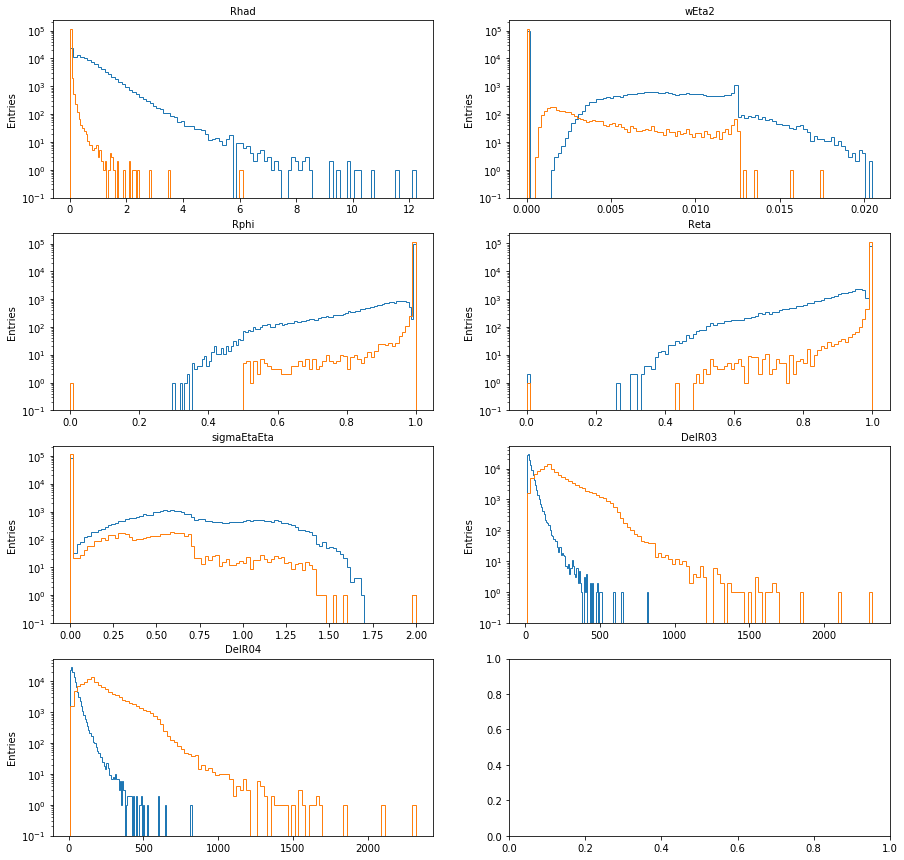

In [9]:
plotHL(bg,sig)

In [10]:
def reportNan(xx):
    for i in range(7):
        print("{} nans in {}".format(np.isnan(xx[:,i])[np.isnan(xx[:,i]) == True].size, lkup[i]))

def delNan(xx):
    return xx[~np.isnan(xx).any(axis=1)]

In [11]:
reportNan(bg)

0 nans in Rhad
7 nans in wEta2
7 nans in Rphi
5 nans in Reta
6 nans in sigmaEtaEta
0 nans in DelR03
0 nans in DelR04


In [12]:
reportNan(sig)

0 nans in Rhad
17 nans in wEta2
15 nans in Rphi
14 nans in Reta
15 nans in sigmaEtaEta
0 nans in DelR03
0 nans in DelR04


In [13]:
bg, sig = delNan(bg), delNan(sig)

In [14]:
print(bg.shape, sig.shape)

(118364, 7) (118354, 7)


In [15]:
x = np.concatenate((bg,sig))
y = np.concatenate((np.zeros(bg.shape[0]),np.ones(sig.shape[0])))

In [16]:
print(x.shape, y.shape)

(236718, 7) (236718,)


In [17]:
x.mean(axis=0)

array([3.34489859e-01, 9.24275342e-04, 9.83470138e-01, 9.78680698e-01,
       1.16181311e-01, 1.25566694e+02, 1.26450422e+02])

In [18]:
reportNan(x)

0 nans in Rhad
0 nans in wEta2
0 nans in Rphi
0 nans in Reta
0 nans in sigmaEtaEta
0 nans in DelR03
0 nans in DelR04


In [19]:
# Standardization:
x = preprocessing.scale(x)
x.mean(axis=0)

array([-3.94789951e-13, -4.30781615e-13,  4.41873439e-13, -3.28127555e-13,
        4.00667716e-13, -1.03383451e-14, -1.37961755e-14])

In [22]:
# Splitting train & validation & test
# train & validation is used for telling overfitting
# test is used for evaluating the model (AUC)
def splitTr(x,y,size,seed):
    x_tr, x_te, y_tr, y_te = train_test_split(x, y, test_size=size, random_state=seed)
    x_tr, x_val, y_tr, y_val = train_test_split(x_tr, y_tr, test_size=size, random_state=seed)
    return x_tr, x_val, x_te, y_tr, y_val, y_te

x_tr, x_val, x_te, y_tr, y_val, y_te = splitTr(x,y,0.2,42)

In [27]:
# Final check for the shape
def printShape(x):
    for i in x:
        print(i.shape)

printShape((x_tr, x_val, x_te, y_tr, y_val, y_te,x,y)) 

(151499, 7)
(37875, 7)
(47344, 7)
(151499,)
(37875,)
(47344,)
(236718, 7)
(236718,)


In [25]:
def splitBgSig(x,y):
    i_bg, i_sig = np.where(y == 0)[0], np.where(y == 1)[0]
    x_bg = x[i_bg]
    x_sig = x[i_sig]
    return x_bg, x_sig

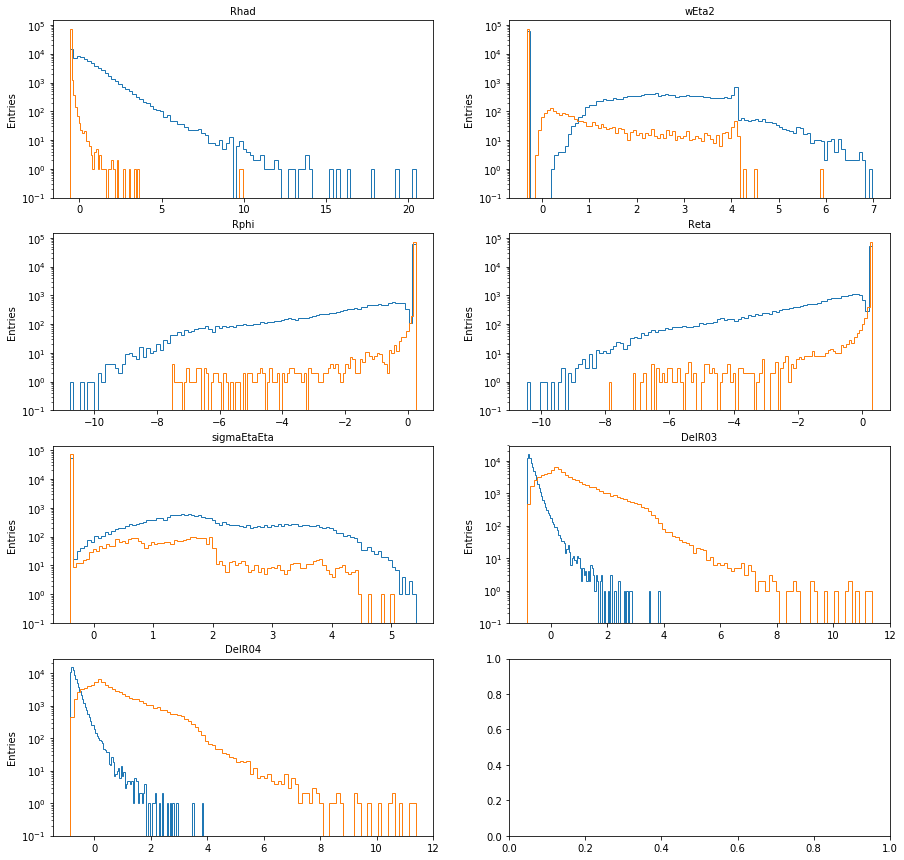

In [26]:
x_tr_bg, x_tr_sig = splitBgSig(x_tr, y_tr)
plotHL(x_tr_bg, x_tr_sig)

In [29]:
def plot_al(history,aorl,t):
    plt.plot(history.history[aorl])
    plt.plot(history.history['val_'+aorl])
    plt.title(t + (" Accuracy" if aorl=="acc" else " Loss"))
    plt.ylabel(aorl)
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
def roc(true,pred,t):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(2):
        fpr[i], tpr[i], _ = roc_curve(true, pred)
        roc_auc[i] = auc(fpr[i], tpr[i])
        
    print(roc_auc)
    plt.figure()
    plt.plot(fpr[1], tpr[1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(['AUC={:.5}'.format(roc_auc[0])], loc='lower right')
    plt.title(t + ' ROC')
    plt.savefig(t+str(roc_auc[0])+".png")
    plt.show()
    return roc_auc[0]
    
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, 
                                           patience=10, verbose=0,
                                           mode='auto', baseline=None,
                                           restore_best_weights=True)]

In [63]:
def run_model(model,x_tr,y_tr,x_val,y_val,x_te,y_te,hlx,p=False,epochs=20,batch=128):
    if type(hlx) == str:
        model.load_weights(('parallel_' if p else '') + 'hlbase_7.h5')
        history = model.fit(x_tr, y_tr, epochs=epochs, batch_size=128, 
                        validation_data=(x_val,y_val),verbose=1,
                        callbacks=callbacks)
        model.save_weights(('parallel_' if p else '') +'hlbase_7_'+'_{}e_{}b.h5'.format(epochs,batch))
        plot_al(history, 'loss', 'HL ALL')
        y_hat = model.predict(x_te)
        y_hat = np.reshape(y_hat,(y_hat.shape[0]))
        auc = roc(y_te, y_hat, 'HL ALL')   
    elif type(hlx) == tuple:
        model.load_weights(('parallel_' if p else '') + 'hlbase_{}.h5'.format(len(hlx)))
        history = model.fit(x_tr[:,hlx,], y_tr, epochs=epochs, batch_size=128, 
                        validation_data=(x_val[:,hlx,],y_val),verbose=1,
                        callbacks=callbacks)
        model.save_weights(('parallel_' if p else '') +'hlbase_{}_{}e_{}b.h5'.format(str(hlx),epochs,batch))
        tt = ''
        for i in hlx:
            tt += lkup[i] 
        plot_al(history, 'loss', 'HL '+tt)
        y_hat = model.predict(x_te[:,hlx,])
        y_hat = np.reshape(y_hat,(y_hat.shape[0]))
        auc = roc(y_te, y_hat, 'HL '+tt)          
    elif type(hlx) == int:
        model.load_weights(('parallel_' if p else '') + 'hlbase_1.h5')
        history = model.fit(x_tr[:,hlx], y_tr, epochs=epochs, batch_size=128, 
                    validation_data=(x_val[:,hlx],y_val),verbose=1,
                    callbacks=callbacks)
        model.save_weights(('parallel_' if p else '') +'hlbase_1_'+'_{}e_{}b.h5'.format(epochs,batch))
        plot_al(history, 'loss', 'HL '+lkup[hlx])
        y_hat = model.predict(x_te[:,hlx])
        y_hat = np.reshape(y_hat,(y_hat.shape[0]))
        auc = roc(y_te, y_hat, 'HL '+lkup[hlx])
    return auc

In [64]:
def run_model_Ntimes(N,model,x,y,hlx,p=False,epochs=20,batch=128):
    aucs = []
    for j in range(N):
        print("\n{}th iteration on {}:".format(j,lkup[hlx] if type(hlx)==int else str(hlx)))
        x_tr, x_val, x_te, y_tr, y_val, y_te = splitTr(x,y,0.2,random.randint(1,100))
        auc = run_model(model,x_tr,y_tr,x_val,y_val,x_te,y_te,hlx,p=p,epochs=epochs,batch=batch)
        aucs.append(auc)
    return aucs

3th HL, Reta

0th iteration on Reta:
Train on 151499 samples, validate on 37875 samples
Epoch 1/200
151499/151499 [==============================] - 9s 60us/step - loss: 0.5991 - val_loss: 0.5958
Epoch 2/200
151499/151499 [==============================] - 9s 61us/step - loss: 0.5972 - val_loss: 0.5958
Epoch 3/200
151499/151499 [==============================] - 9s 58us/step - loss: 0.5971 - val_loss: 0.5957
Epoch 4/200
151499/151499 [==============================] - 9s 59us/step - loss: 0.5970 - val_loss: 0.5958
Epoch 5/200
151499/151499 [==============================] - 9s 57us/step - loss: 0.5970 - val_loss: 0.5959
Epoch 6/200
151499/151499 [==============================] - 9s 57us/step - loss: 0.5969 - val_loss: 0.5956
Epoch 7/200
151499/151499 [==============================] - 9s 57us/step - loss: 0.5969 - val_loss: 0.5956
Epoch 8/200
151499/151499 [==============================] - 9s 59us/step - loss: 0.5968 - val_loss: 0.5960
Epoch 9/200
151499/151499 [=====================

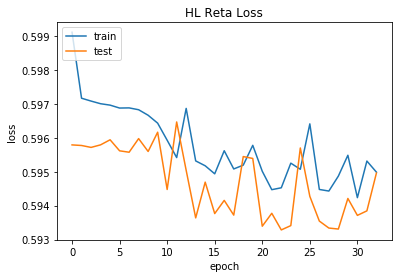

{0: 0.6419847576597915, 1: 0.6419847576597915}


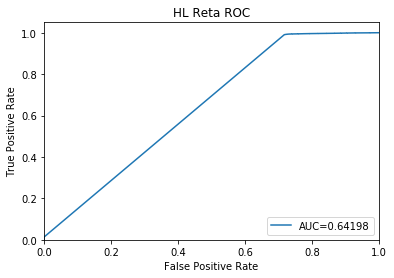


1th iteration on Reta:
Train on 151499 samples, validate on 37875 samples
Epoch 1/200
151499/151499 [==============================] - 5s 33us/step - loss: 0.5997 - val_loss: 0.5970
Epoch 2/200
151499/151499 [==============================] - 5s 32us/step - loss: 0.5974 - val_loss: 0.5969
Epoch 3/200
151499/151499 [==============================] - 5s 32us/step - loss: 0.5973 - val_loss: 0.5979
Epoch 4/200
151499/151499 [==============================] - 5s 33us/step - loss: 0.5973 - val_loss: 0.5970
Epoch 5/200
151499/151499 [==============================] - 5s 33us/step - loss: 0.5972 - val_loss: 0.5969
Epoch 6/200
151499/151499 [==============================] - 5s 32us/step - loss: 0.5971 - val_loss: 0.5971
Epoch 7/200
151499/151499 [==============================] - 5s 32us/step - loss: 0.5972 - val_loss: 0.5969
Epoch 8/200
151499/151499 [==============================] - 5s 33us/step - loss: 0.5971 - val_loss: 0.5970
Epoch 9/200
151499/151499 [==============================] - 

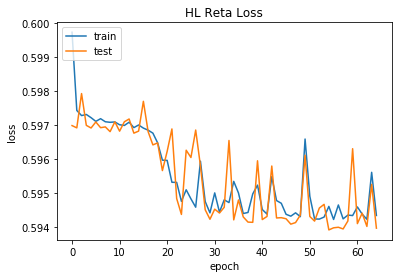

{0: 0.6446744495715766, 1: 0.6446744495715766}


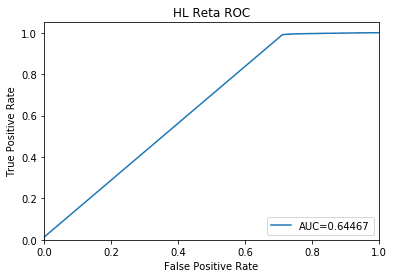


2th iteration on Reta:
Train on 151499 samples, validate on 37875 samples
Epoch 1/200
151499/151499 [==============================] - 9s 60us/step - loss: 0.5987 - val_loss: 0.5983
Epoch 2/200
151499/151499 [==============================] - 9s 60us/step - loss: 0.5973 - val_loss: 0.5987
Epoch 3/200
151499/151499 [==============================] - 9s 60us/step - loss: 0.5972 - val_loss: 0.5984
Epoch 4/200
151499/151499 [==============================] - 9s 60us/step - loss: 0.5972 - val_loss: 0.5984
Epoch 5/200
151499/151499 [==============================] - 9s 60us/step - loss: 0.5971 - val_loss: 0.5982
Epoch 6/200
151499/151499 [==============================] - 9s 61us/step - loss: 0.5970 - val_loss: 0.5986
Epoch 7/200
151499/151499 [==============================] - 9s 60us/step - loss: 0.5970 - val_loss: 0.5979
Epoch 8/200
151499/151499 [==============================] - 9s 57us/step - loss: 0.5969 - val_loss: 0.5982
Epoch 9/200
151499/151499 [==============================] - 

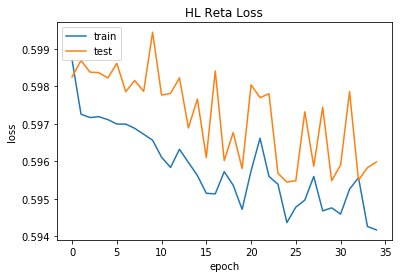

{0: 0.6430487816673893, 1: 0.6430487816673893}


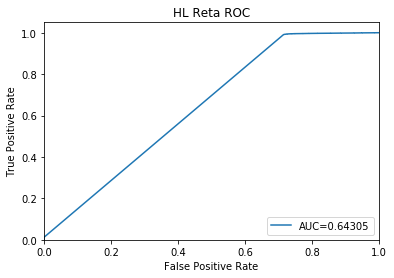


3th iteration on Reta:
Train on 151499 samples, validate on 37875 samples
Epoch 1/200
151499/151499 [==============================] - 9s 58us/step - loss: 0.5999 - val_loss: 0.6006
Epoch 2/200
151499/151499 [==============================] - 9s 60us/step - loss: 0.5980 - val_loss: 0.6006
Epoch 3/200
151499/151499 [==============================] - 9s 57us/step - loss: 0.5979 - val_loss: 0.6003
Epoch 4/200
151499/151499 [==============================] - 9s 58us/step - loss: 0.5979 - val_loss: 0.6011
Epoch 5/200
151499/151499 [==============================] - 9s 60us/step - loss: 0.5978 - val_loss: 0.6008
Epoch 6/200
151499/151499 [==============================] - 9s 61us/step - loss: 0.5978 - val_loss: 0.6007
Epoch 7/200
151499/151499 [==============================] - 9s 60us/step - loss: 0.5978 - val_loss: 0.6010
Epoch 8/200
151499/151499 [==============================] - 9s 59us/step - loss: 0.5977 - val_loss: 0.6012
Epoch 9/200
151499/151499 [==============================] - 

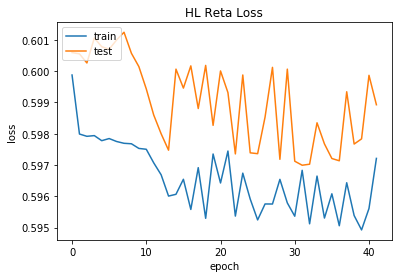

{0: 0.6474935692591681, 1: 0.6474935692591681}


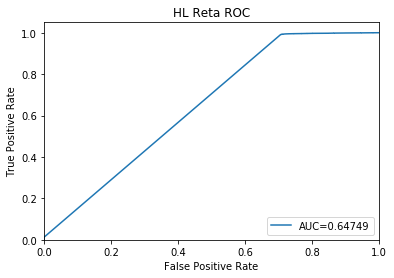


4th iteration on Reta:
Train on 151499 samples, validate on 37875 samples
Epoch 1/200
151499/151499 [==============================] - 9s 58us/step - loss: 0.5991 - val_loss: 0.5988
Epoch 2/200
151499/151499 [==============================] - 9s 57us/step - loss: 0.5976 - val_loss: 0.5979
Epoch 3/200
151499/151499 [==============================] - 9s 58us/step - loss: 0.5974 - val_loss: 0.5975
Epoch 4/200
151499/151499 [==============================] - 9s 58us/step - loss: 0.5974 - val_loss: 0.5976
Epoch 5/200
151499/151499 [==============================] - 9s 57us/step - loss: 0.5972 - val_loss: 0.5976
Epoch 6/200
151499/151499 [==============================] - 9s 59us/step - loss: 0.5972 - val_loss: 0.5978
Epoch 7/200
151499/151499 [==============================] - 9s 60us/step - loss: 0.5971 - val_loss: 0.5980
Epoch 8/200
151499/151499 [==============================] - 9s 60us/step - loss: 0.5972 - val_loss: 0.5971
Epoch 9/200
151499/151499 [==============================] - 

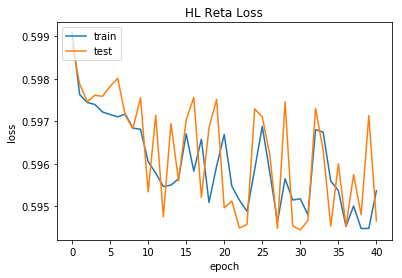

{0: 0.6430955710475502, 1: 0.6430955710475502}


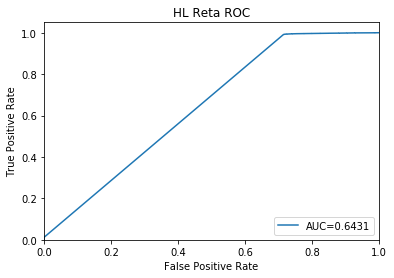


5th iteration on Reta:
Train on 151499 samples, validate on 37875 samples
Epoch 1/200
151499/151499 [==============================] - 9s 57us/step - loss: 0.5995 - val_loss: 0.5974
Epoch 2/200
151499/151499 [==============================] - 9s 57us/step - loss: 0.5981 - val_loss: 0.5969
Epoch 3/200
151499/151499 [==============================] - 9s 58us/step - loss: 0.5979 - val_loss: 0.5973
Epoch 4/200
151499/151499 [==============================] - 9s 60us/step - loss: 0.5979 - val_loss: 0.5970
Epoch 5/200
151499/151499 [==============================] - 9s 60us/step - loss: 0.5979 - val_loss: 0.5969
Epoch 6/200
151499/151499 [==============================] - 9s 60us/step - loss: 0.5977 - val_loss: 0.5970
Epoch 7/200
151499/151499 [==============================] - 9s 60us/step - loss: 0.5978 - val_loss: 0.5971
Epoch 8/200
151499/151499 [==============================] - 9s 60us/step - loss: 0.5977 - val_loss: 0.5973
Epoch 9/200
151499/151499 [==============================] - 

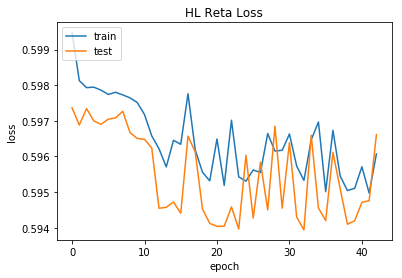

{0: 0.6460591918686986, 1: 0.6460591918686986}


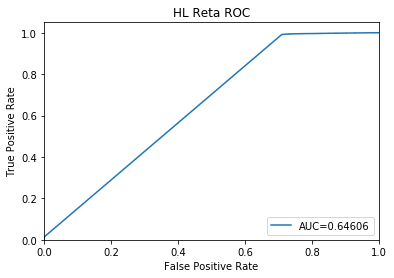


6th iteration on Reta:
Train on 151499 samples, validate on 37875 samples
Epoch 1/200
151499/151499 [==============================] - 9s 59us/step - loss: 0.5994 - val_loss: 0.5985
Epoch 2/200
151499/151499 [==============================] - 9s 60us/step - loss: 0.5972 - val_loss: 0.5990
Epoch 3/200
151499/151499 [==============================] - 9s 59us/step - loss: 0.5970 - val_loss: 0.5978
Epoch 4/200
151499/151499 [==============================] - 9s 58us/step - loss: 0.5969 - val_loss: 0.5983
Epoch 5/200
151499/151499 [==============================] - 9s 58us/step - loss: 0.5969 - val_loss: 0.5981
Epoch 6/200
151499/151499 [==============================] - 9s 58us/step - loss: 0.5969 - val_loss: 0.5980
Epoch 7/200
151499/151499 [==============================] - 9s 59us/step - loss: 0.5968 - val_loss: 0.5975
Epoch 8/200
151499/151499 [==============================] - 9s 60us/step - loss: 0.5966 - val_loss: 0.5976
Epoch 9/200
151499/151499 [==============================] - 

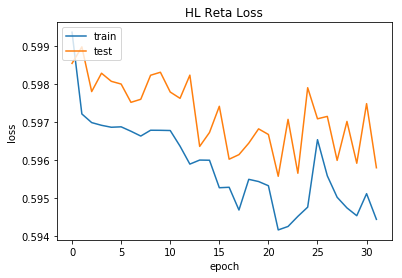

{0: 0.6432340314795634, 1: 0.6432340314795634}


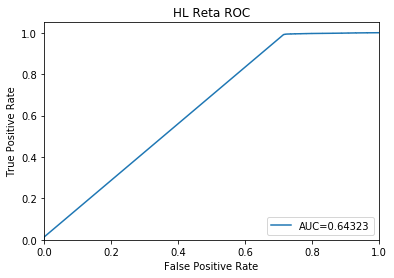


7th iteration on Reta:
Train on 151499 samples, validate on 37875 samples
Epoch 1/200
151499/151499 [==============================] - 5s 33us/step - loss: 0.6001 - val_loss: 0.5970
Epoch 2/200
151499/151499 [==============================] - 5s 32us/step - loss: 0.5982 - val_loss: 0.5966
Epoch 3/200
151499/151499 [==============================] - 5s 32us/step - loss: 0.5980 - val_loss: 0.5966
Epoch 4/200
151499/151499 [==============================] - 5s 32us/step - loss: 0.5980 - val_loss: 0.5969
Epoch 5/200
151499/151499 [==============================] - 5s 32us/step - loss: 0.5980 - val_loss: 0.5968
Epoch 6/200
151499/151499 [==============================] - 5s 32us/step - loss: 0.5979 - val_loss: 0.5968
Epoch 7/200
151499/151499 [==============================] - 5s 32us/step - loss: 0.5979 - val_loss: 0.5970
Epoch 8/200
151499/151499 [==============================] - 5s 32us/step - loss: 0.5978 - val_loss: 0.5973
Epoch 9/200
151499/151499 [==============================] - 

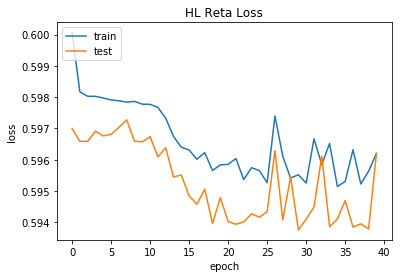

{0: 0.6461174563670392, 1: 0.6461174563670392}


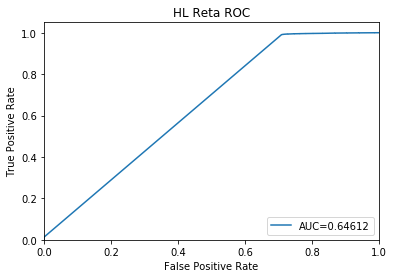


8th iteration on Reta:
Train on 151499 samples, validate on 37875 samples
Epoch 1/200
151499/151499 [==============================] - 5s 33us/step - loss: 0.6006 - val_loss: 0.5970
Epoch 2/200
151499/151499 [==============================] - 5s 33us/step - loss: 0.5983 - val_loss: 0.5961
Epoch 3/200
151499/151499 [==============================] - 5s 32us/step - loss: 0.5982 - val_loss: 0.5958
Epoch 4/200
151499/151499 [==============================] - 5s 32us/step - loss: 0.5982 - val_loss: 0.5961
Epoch 5/200
151499/151499 [==============================] - 5s 33us/step - loss: 0.5981 - val_loss: 0.5961
Epoch 6/200
151499/151499 [==============================] - 5s 32us/step - loss: 0.5980 - val_loss: 0.5962
Epoch 7/200
151499/151499 [==============================] - 5s 32us/step - loss: 0.5979 - val_loss: 0.5958
Epoch 8/200
151499/151499 [==============================] - 5s 33us/step - loss: 0.5979 - val_loss: 0.5959
Epoch 9/200
151499/151499 [==============================] - 

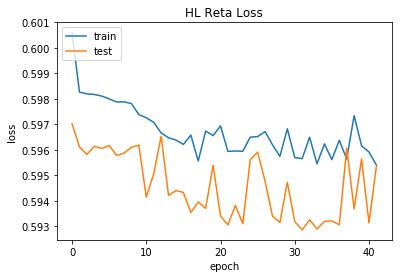

{0: 0.6450635996797343, 1: 0.6450635996797343}


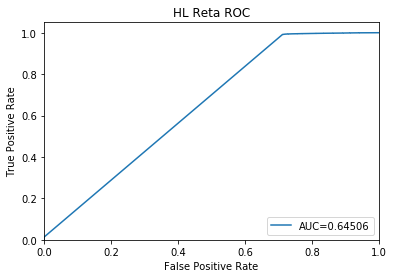


9th iteration on Reta:
Train on 151499 samples, validate on 37875 samples
Epoch 1/200
151499/151499 [==============================] - 5s 33us/step - loss: 0.5991 - val_loss: 0.5977
Epoch 2/200
151499/151499 [==============================] - 5s 32us/step - loss: 0.5973 - val_loss: 0.5964
Epoch 3/200
151499/151499 [==============================] - 5s 32us/step - loss: 0.5970 - val_loss: 0.5959
Epoch 4/200
151499/151499 [==============================] - 5s 32us/step - loss: 0.5970 - val_loss: 0.5965
Epoch 5/200
151499/151499 [==============================] - 5s 32us/step - loss: 0.5970 - val_loss: 0.5956
Epoch 6/200
151499/151499 [==============================] - 5s 32us/step - loss: 0.5969 - val_loss: 0.5960
Epoch 7/200
151499/151499 [==============================] - 5s 33us/step - loss: 0.5969 - val_loss: 0.5956
Epoch 8/200
151499/151499 [==============================] - 5s 32us/step - loss: 0.5966 - val_loss: 0.5955
Epoch 9/200
151499/151499 [==============================] - 

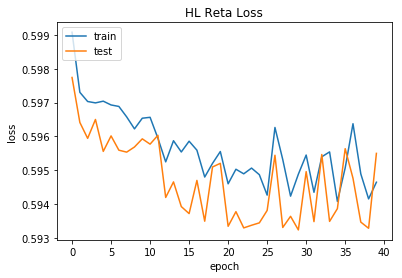

{0: 0.6420484513096449, 1: 0.6420484513096449}


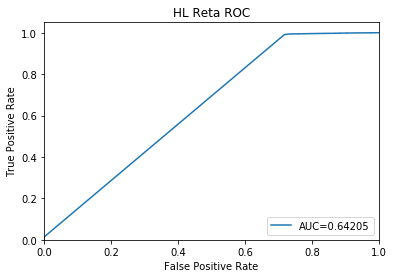

Reta [0.6419847576597915, 0.6446744495715766, 0.6430487816673893, 0.6474935692591681, 0.6430955710475502, 0.6460591918686986, 0.6432340314795634, 0.6461174563670392, 0.6450635996797343, 0.6420484513096449]


In [43]:
aucss = dict()
for i in range(3,4):
    print("{}th HL, {}".format(i,lkup[i]))
    aucs = run_model_Ntimes(10,model,x,y,i,p=False,epochs=200,batch=128)
    print(lkup[i],aucs)
    aucss[lkup[i]] = aucs

In [71]:
aucs = run_model_Ntimes(10,model_3,x,y,(0,5,6),p=False,epochs=200,batch=128)
print(aucs)
aucss[str((0,5,6))] = aucs


0th iteration on (0, 5, 6):
Train on 151499 samples, validate on 37875 samples
Epoch 1/200
 84736/151499 [===============>..............] - ETA: 2s - loss: 0.0898

KeyboardInterrupt: 

In [65]:
aucs = run_model_Ntimes(10,model,x,y,"all",p=False,epochs=200,batch=128)
print(aucs)
aucss["all"] = aucs


0th iteration on all:
Train on 151499 samples, validate on 37875 samples
Epoch 1/200
151499/151499 [==============================] - 6s 39us/step - loss: 0.0641 - val_loss: 0.0604
Epoch 2/200
143616/151499 [===========================>..] - ETA: 0s - loss: 0.0567

KeyboardInterrupt: 

In [61]:
print(aucss)

{'Reta': [0.6419847576597915, 0.6446744495715766, 0.6430487816673893, 0.6474935692591681, 0.6430955710475502, 0.6460591918686986, 0.6432340314795634, 0.6461174563670392, 0.6450635996797343, 0.6420484513096449], 'all': [0.9980470576802363, 0.9981086640034519, 0.9980535998798739, 0.9980138565334152, 0.9980797163614233, 0.9980430839206216, 0.9980700442729691, 0.9980877638064259, 0.9980317457533551, 0.9978831900221503]}
